In [ ]:
# method name: Stock Market Classification Algorithm
# purpose: This script uses data from the previous data preprocessing algorithm to classify possible trades
# created: 6/14/2020 5:01PM
# Author: Zack Stinnett

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
stock_data = pd.read_csv('DataPreprocessingResults.csv')

In [3]:
#Encoding stock symbols with numerical values
label_encoder = LabelEncoder()

In [4]:
stock_data['Symbol'] = label_encoder.fit_transform(stock_data['Symbol'])

In [5]:
# Need to scale values in the data to allow the classification algorithms to work better. 
from sklearn.preprocessing import StandardScaler
def rescale(data):
    data = data.dropna().astype('float')
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [6]:
# Fixing infinite values before using scaler
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [7]:
# Splitting manually on a date vs randomly to avoid leakage
train_data = stock_data[stock_data['Date']<'2020-06-03']
test_data = stock_data[stock_data['Date']>='2020-06-03']

train_data.drop(['Date'], axis=1, inplace=True)
test_data.drop(['Date'], axis=1, inplace=True)

train_data = clean_dataset(train_data)
test_data = clean_dataset(test_data)

train_X, train_y = train_data.drop(['Signals'],axis=1), train_data['Signals']
test_X, test_y   = test_data.drop(['Signals'],axis=1),  test_data['Signals']

C:\Users\zackarys\AppData\Local\Continuum\anaconda3\envs\devenv\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\zackarys\AppData\Local\Continuum\anaconda3\envs\devenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
scaled_train_X = rescale(train_X)
scaled_test_X = rescale(test_X)

In [9]:
# Version needs to be at least 0.22 for the ensemble stacking to work.
import sklearn
print(sklearn.__version__)

0.22.1


In [10]:
# Code for the following comes from the stacking section from: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# Was introduced to the idea in Advances in Financial Machine Learning by Marcos Lopez de Prado 

In [11]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))     #Analysis showed this model underperformed
    level0.append(('knn', KNeighborsClassifier()))   #Analysis showed this model underperformed
    level0.append(('rf_1',RandomForestClassifier(class_weight='balanced')))
    level0.append(('rf_2',RandomForestClassifier(class_weight='balanced_subsample')))
    level0.append(('cart', DecisionTreeClassifier()))
    
    # define meta learner model
    level1 = RandomForestClassifier()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [12]:
# get a list of models to evaluate
def get_models():
    models = dict()
    #models['lr'] = LogisticRegression()     #Analysis showed this model underperformed
    #models['knn'] = KNeighborsClassifier()   #Analysis showed this model underperformed
    models['rf_1'] = RandomForestClassifier(class_weight='balanced')
    models['rf_2'] = RandomForestClassifier(class_weight='balanced_subsample')
    models['xgb'] = XGBClassifier(num_classes=3)
    #models['bayes'] =  GaussianNB()        #Analysis showed this model underperformed
    models['stacking'] = get_stacking()
    return models

In [13]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, scaled_train_X, train_y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [14]:
models = get_models()

In [15]:
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('Model {} had {:.0%} training accuracy with a {:.0} standard deviation.'.format(name, np.mean(scores), np.std(scores)))

Model rf_1 had 87% training accuracy with a 0.01 standard deviation.
Model rf_2 had 87% training accuracy with a 0.01 standard deviation.
Model xgb had 67% training accuracy with a 0.02 standard deviation.
Model stacking had 58% training accuracy with a 0.01 standard deviation.


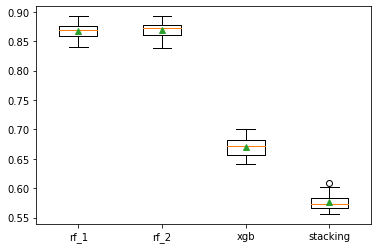

In [16]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# The stacking algorithm ended up not performing nearly as well as the random forest algorithms. 

In [17]:
# random forest model creation
score = evaluate_model(models['rf_1'])
print('Model {} had {:.0%} training accuracy with a {:.0} standard deviation.'.format(name, np.mean(score), np.std(score)))

Model stacking had 87% training accuracy with a 0.01 standard deviation.


In [18]:
print("=== All AUC Scores ===")
print(score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", score.mean())

=== All AUC Scores ===
[0.8798627  0.85354691 0.88558352 0.85354691 0.8604119  0.83848797
 0.88087056 0.88545246 0.87056128 0.87056128 0.88443936 0.86613272
 0.87643021 0.87643021 0.86498856 0.85681558 0.86597938 0.89232532
 0.85223368 0.87514318 0.87757437 0.86155606 0.86842105 0.89359268
 0.88329519 0.87056128 0.86941581 0.84421535 0.86139748 0.86941581]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8696416261032082


In [19]:
# Didn't do any hyperparameter turning since the AUC is already close to 0.90, indicating a great model already
# Now to create a portfolio from the predictions after saving this data.

In [20]:
y_pred = cross_val_predict(model, scaled_test_X, test_y, cv=10)

C:\Users\zackarys\AppData\Local\Continuum\anaconda3\envs\devenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
print('The Cross Validated Prediction Accuracy was: {:.0%}'.format(accuracy_score(test_y, y_pred)))

The Cross Validated Prediction Accuracy was: 75%


In [22]:
test_X['Prediction'] = y_pred

In [23]:
test_X['Symbol'] = label_encoder.inverse_transform(test_X['Symbol'].astype(int))

In [25]:
test_X['Signal'] = test_y

In [26]:
test_X.to_csv('StockDataWithPredictions.csv')